In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import albumentations as A

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CustomCelebA(CelebA):
    def __init__(self, root='/media/mountHDD2/data', split='train', download=True, 
                 target_type=['attr', 'identity', 'landmarks']):
        super().__init__(root=root, split=split, target_type=target_type, download=download)

        self.__transform = A.Compose(
            [
                A.Resize(64, 64),
                A.HorizontalFlip(p=0.2),
                A.Normalize(
                    mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
                )
            ], 
            keypoint_params=A.KeypointParams(format='xy')
        )

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        pil_img, raw_targets = super().__getitem__(idx)

        np_img = np.array(pil_img)

        raw_attr = raw_targets[0]
        raw_idty = raw_targets[1]
        raw_ldmk = raw_targets[2].numpy().reshape(5, 2).tolist()

        transformed = self.__transform(image=np_img, keypoints=raw_ldmk)
        transformed_img = transformed['image']
        transformed_key = transformed['keypoints']

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1)

        targets = {
            "attr" : raw_attr,
            "idty" : raw_idty,
            "keypoints" : transformed_key
        }

        return torch_img, raw_targets

In [3]:
sample_ds = CustomCelebA(split='test')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
(tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]), tensor(7760), tensor([ 68, 111, 108, 112,  93, 137,  70, 152, 108, 151]))


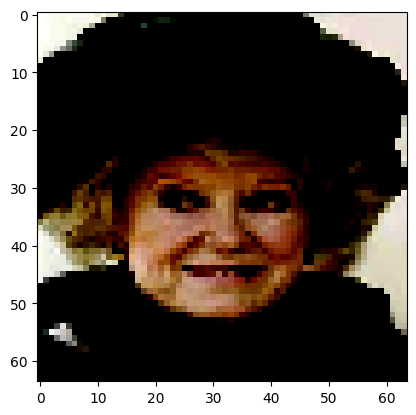

In [4]:
img, targets = sample_ds[0]
print(img.shape)
print(targets)

plt.imshow(img.permute(1, -1, 0).numpy())